This is a tutorial on how reverberating super bursts were detected in Pradeepan et al., 2023. **This is a non-reverberating network example**


---


DISCLAIMER: The approach used in the manuscript relies upon the generation of spike density functions - to convert a discrete, analog signal (i.e., 1s and 0s) into a continuous one (i.e., spike density function). By doing so, we are theoretically changing the signal into something it is not. However, through careful interrogation, we have assured the questions we asked are not biased by this step.

To navigate around this issue, I have also developed a different approach. This "secondary approach" avoids the convolution of a kernel and relies upon my implementation of the Max Interval Burst Detection algorithm combined with a histogram-based approach to detecting network events. By combining these two approaches, we're able to cut the run time of the analysis by up to 95%, however the trade off is the accuracy of burst boundaries. Nonetheless, the results are still comparable. This secondary approach will be shared in this document as a hyperlink, including a separate tutorial at another time.

## Install necessary packages

Requirements: Pandas, Numpy, Matplotlib, Seaborn, Math, Scipy, Sci-kit learn

## Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm
from scipy.signal import convolve
from scipy.signal import find_peaks
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from scipy.stats import skew
from scipy.stats import mode



In [5]:
filename = "/content/drive/MyDrive/Colab Notebooks/spike_data.csv"
fs = 12500

## Convert Axion Biosystem's spike_list.csv file into a dataframe

In [6]:
def organize_spikelist(filepath):
    # Create neuralMetric dataframe
    spikelist_file = pd.read_csv(filepath, sep='\r\n', header=None)
    spikelist_file = spikelist_file[0].str.split(',', expand=True)
    spikelist_file.columns = spikelist_file.iloc[0]
    spikelist_file = spikelist_file.iloc[1:]

    spiketimes = spikelist_file[["Time (s)", "Electrode"]]
    spiketimes = spiketimes.iloc[:-8]
    spiketimes = spiketimes.dropna()
    spiketimes = spiketimes[spiketimes["Electrode"].str.contains("_")]
    spiketimes = spiketimes.astype({"Time (s)": float})
    spiketimes["Well"] = [electrode.split("_")[0] for electrode in list(spiketimes["Electrode"].values)]
    spiketimes["Channel"] = [electrode.split("_")[1] for electrode in list(spiketimes["Electrode"].values)]

    r,c = np.where(spikelist_file == "Well Information")
    metadata_slice = spikelist_file.iloc[r[0]:].transpose().reset_index()
    metadata_slice.columns = metadata_slice.iloc[0]
    metadata_slice = metadata_slice.iloc[1:]
    metadata = {}
    label = []
    for i, well in enumerate(metadata_slice["Well"]):
        if well != None:
            metadata[well] = metadata_slice.iloc[i]["Treatment"]
            label.append(str(well)+"-"+str(metadata_slice.iloc[i]["Treatment"]))

    return spiketimes, metadata, label

spiketimes, metadata, label = organize_spikelist(filename)

<ipython-input-6-2eeb288d4c56>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  spikelist_file = pd.read_csv(filepath, sep='\r\n', header=None)


In [7]:
spiketimes.head()

,Time (s),Electrode,Well,Channel
1,0.00184,A1_76,A1,76
2,0.00824,C1_51,C1,51
3,0.01160,B1_47,B1,47
4,0.01984,A1_42,A1,42
5,0.02224,C1_41,C1,41


In [8]:
spiketimes["Well"].unique()

array(['A1', 'C1', 'B1', 'A4', 'C2', 'B2', 'B4', 'A2', 'C3', 'C4', 'B3',
       'A3'], dtype=object)

In [9]:
spiketimes["Channel"].unique()

array(['76', '51', '47', '42', '41', '16', '26', '13', '18', '31', '84',
       '44', '82', '38', '85', '32', '88', '78', '11', '72', '87', '75',
       '48', '62', '24', '65', '63', '25', '15', '43', '81', '61', '46',
       '58', '83', '55', '57', '52', '12', '73', '22', '56', '67', '77',
       '66', '53', '36', '74', '86', '45', '23', '33', '21', '14', '71',
       '17', '37', '35', '28', '54', '27', '34', '68', '64'], dtype=object)

In [10]:
duration = int(math.ceil(max(spiketimes["Time (s)"])/100.0))*100
print(f"It appears the duration of these recordings was {duration} seconds.")

It appears the duration of these recordings was 300 seconds.


The data that we'll be dealing with are spike times from a 12-well multielectrode array system. Each well contains 64 channels (arranged in an 8x8 grid). Channels are labeled according to a cartesian coordinate system where the first digit represents x (or the row) and the second digit represents y (or the column).

## Select a well to analyze
This is where you would start wrapping the below code into a loop that iterates through each well, each plate/recording.

In [11]:
well_id = "B1"

## Quick look at the network activity
Here we are plotting a histogram of spike times from the well we selected, using a bin size of 0.1 seconds (300 second duration/3000 bins).

Text(0.5, 1.0, 'Sort of like a PSTH - representing network activity')

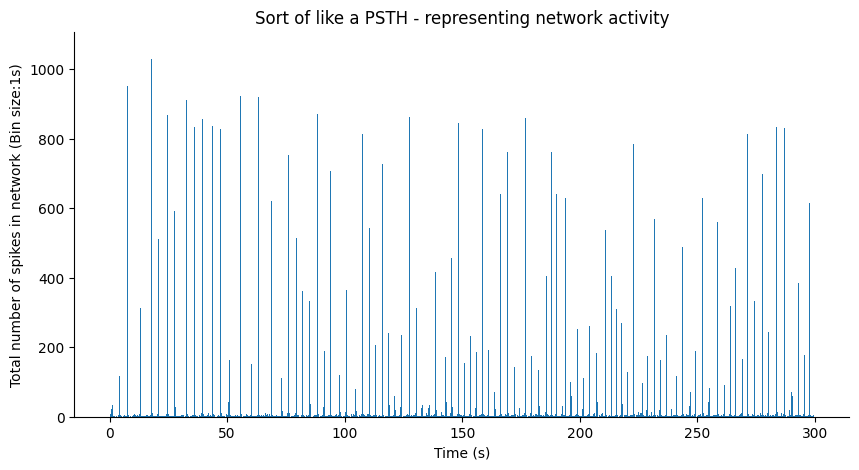

In [12]:
plt.figure(figsize=(10,5))
plt.hist(spiketimes[spiketimes["Well"]==well_id]["Time (s)"], bins=3000);
sns.despine()
plt.xlabel("Time (s)")
plt.ylabel("Total number of spikes in network (Bin size:1s)")
plt.title("Sort of like a PSTH - representing network activity")

It looks like this network is a non-reverberating network. Each large amplitude firing rate event does not appear to have a tail.

We'll plot a close up of a smaller window.

Text(0.5, 1.0, 'Multiple peaks within a network event')

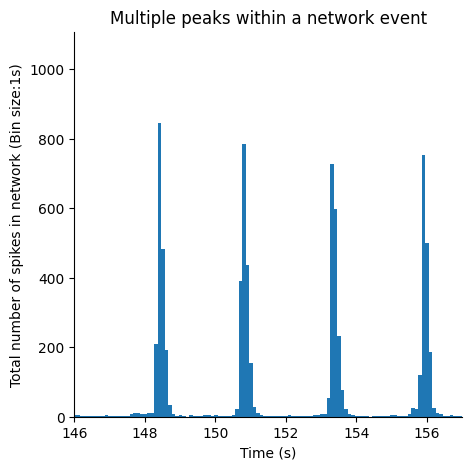

In [13]:
# Definitely do not keep plotting histograms with large bin sizes if you want your code to run fast
plt.figure(figsize=(5,5))
plt.hist(spiketimes[spiketimes["Well"]==well_id]["Time (s)"], bins=3000);
sns.despine()
plt.xlim(146, 157)
plt.xlabel("Time (s)")
plt.ylabel("Total number of spikes in network (Bin size:1s)")
plt.title("Single peak within a network event")

## Sort data frame containing mixed-bag of electrode and spike times based on channel name


In [14]:
channel_ids = [i for j in range(1, 9) for i in range(j * 10 + 1, j * 10 + 9)]
'''
The above produces the following:
  [11, 12, 13, 14, 15, 16, 17, 18,
  21, 22, 23, 24, 25, 26, 27, 28,
  31, 32, 33, 34, 35, 36, 37, 38,
  41, 42, 43, 44, 45, 46, 47, 48,
  51, 52, 53, 54, 55, 56, 57, 58,
  61, 62, 63, 64, 65, 66, 67, 68,
  71, 72, 73, 74, 75, 76, 77, 78,
  81, 82, 83, 84, 85, 86, 87, 88]
'''

def generate_raster(spiketimes, well_id, duration, channel_ids):
  '''
  well_data: Data frame in the format seen above
  duration: Length of recording in seconds (in this case 300 seconds)
  channel_ids: Name of all channels in the format seen in the data frame "channel" column
  '''
  raster = []
  # Loop through each channel regardless of activity
  well_spiketimes = spiketimes[spiketimes["Well"] == well_id].reset_index(drop=True)
  for channel in channel_ids:
    # If the channel is found in my data (i.e., it had at least 1 spike)
    if str(channel) in well_spiketimes["Channel"].to_list():
      # Find spike times associated with that channel
      spiketrain = well_spiketimes.loc[well_spiketimes["Channel"]==str(channel), well_spiketimes.columns.str.contains("Time")].reset_index(drop=True)
      # Convert spike times that occur before the end of the recording (i.e., duration) to an array
      spiketrain = spiketrain.to_numpy().flatten()[spiketrain.to_numpy().flatten() <= duration]
      # Store array
      raster.append(spiketrain)
    # If the channel is not found in my data, I still want to store that it was empty
    else:
      raster.append([])
  return raster

raster = generate_raster(spiketimes, well_id, duration, channel_ids)

## Visualize network activity (as a raster plot)

Text(0.5, 0, 'Time (s)')

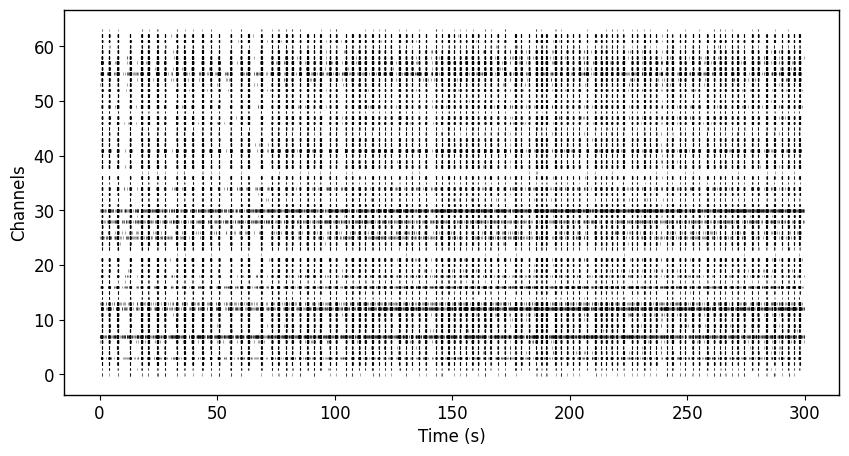

In [15]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.ylabel("Channels")
plt.xlabel("Time (s)")

We did it with the histogram, might as well do it with the raster. 🤷

Text(0.5, 0, 'Time (s)')

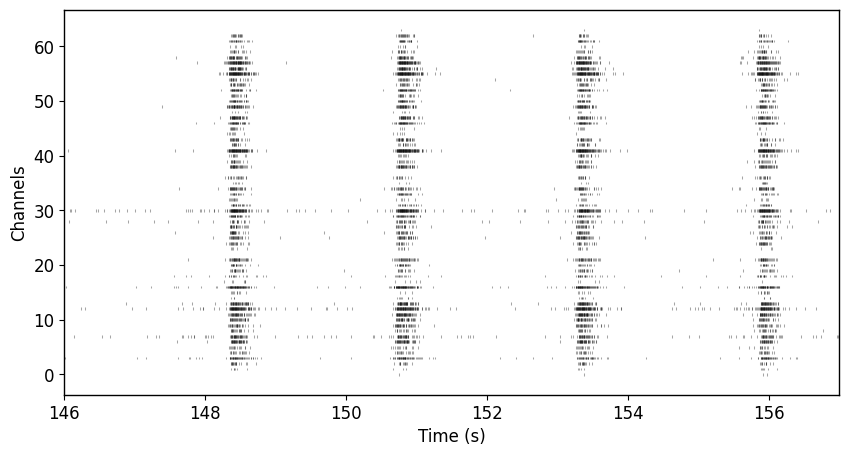

In [16]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.xlim(146, 157)
plt.ylabel("Channels")
plt.xlabel("Time (s)")

# Signal Conditioning

## Approach 1: Generate spike density function

### Gaussian Kernel
Note: You should be using a bandwidth optimized kernel. Refer to Shimazaki & Shinomoto, 2010)

In [17]:
def generate_gaussian_kernel(sigma=0.1, fs=12500):
    '''
    :param sigma: Width of kernel
    :param fs: Sampling frequency in Hz
    :return: Gaussian kernel
    '''
    edges = np.arange(-3 * sigma, 3 * sigma, 1 / fs)
    kernel = norm.pdf(edges, 0, sigma)
    kernel = kernel / max(kernel)
    return kernel

### Binary spike matrix
Create a matrix of nChannels x Y time points, where Y is the duration * sampling frequency.
Each cell will contain either a 0 or 1 depending on whether a spike was found i.e., 1 or not i.e., 0.

In [18]:
def generate_spikematrix(spiketrain, fs=12500, duration=300):
    '''
    :param spiketrain: Takes spikes times from a single channel
    :param fs: Sampling frequency in Hz
    :param duration: Duration of recording in seconds
    :return: spikematrix: Binary matrix containing spikes
    '''
    spiketimes = np.array(spiketrain)
    spiketimes = spiketimes[spiketimes <= duration]  # Ensure recording is desired length
    spikematrix = [0] * (duration * fs)  # Generate empty spike matrix with appropriate number of bins
    for spike in spiketimes:
        spikematrix[int(spike * fs)] = 1
    return spikematrix

### Convolve gaussian kernel and spike matrix


In [19]:
def generate_sdf(spikematrix, gaussian_kernel):
    '''
    :param spikematrix: Binary matrix containing spikes
    :param gaussian_kernel: Gaussian kernel to be convolved with spikematrix
    :return: sdf: Continuous timeseries representing probability distribution of activity
    '''
    sdf_tmp = convolve(spikematrix, gaussian_kernel)
    sdf = sdf_tmp[int((len(sdf_tmp)-len(spikematrix))/2):int(len(sdf_tmp)-((len(sdf_tmp)-len(spikematrix))/2))]
    sdf = sdf/max(gaussian_kernel)
    return sdf

### Iterate through each channel, and generate the channel's SDF
Convolution takes some time because the spike matrix is quite large. There is a way to avoid spike density function generation by relying solely on histograms (like you saw above) but the timing of network event boundaries will be less precise.

In [20]:
kernel = generate_gaussian_kernel(sigma=0.075)

maxFR, channel_sdf = [], []
for n, channel in enumerate(channel_ids):
  spiketrain = raster[n]
  channel_spikematrix = generate_spikematrix(spiketrain, fs=fs, duration=duration)
  sdf_tmp = generate_sdf(channel_spikematrix, kernel)
  channel_sdf.append(sdf_tmp)
  maxFR.append(max(sdf_tmp))

In [21]:
network_sdf = np.mean(channel_sdf, axis=0)
weighted_network_sdf = np.average(channel_sdf, axis=0, weights=maxFR)

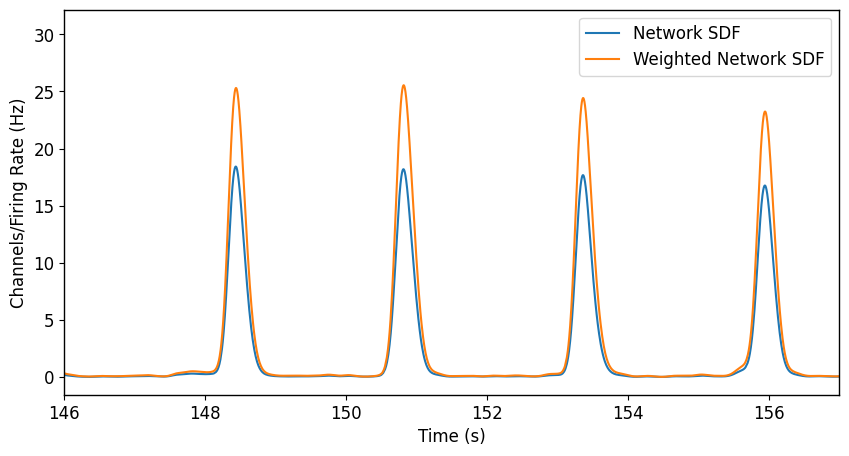

In [22]:
plt.figure(figsize=(10,5))
t = np.arange(0,duration,1/12500)
plt.plot(t,network_sdf)
plt.plot(t,weighted_network_sdf)
plt.xlim(146, 157)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")
plt.legend(["Network SDF", "Weighted Network SDF"])

As you can see, the general shape of the spike density function (which is an estimate of the network's instantaneous firing rate) is the same between the non-maxFR-weighted SDF and the maxFR-weighted SDF. You can use whichever one, but I prefer to use the maxFR-weighted SDF because it helps improve signal:noise for subsequent analysis.

## Visualize raster plot and spike density function

Text(0.5, 0, 'Time (s)')

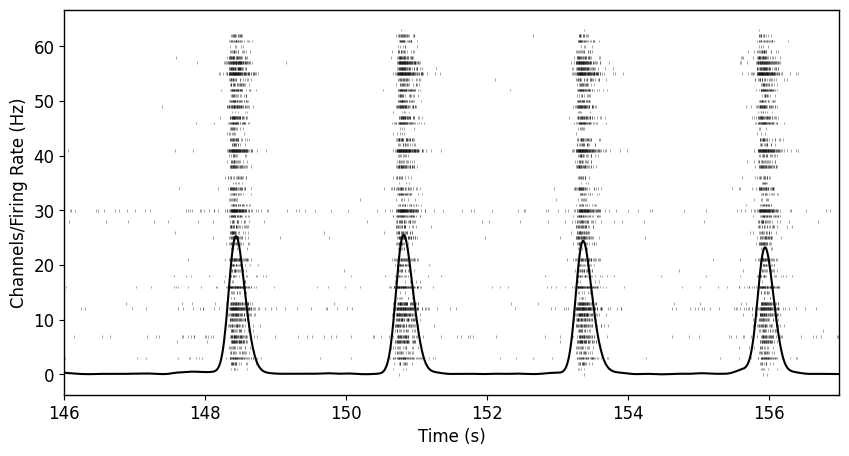

In [23]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
t = np.arange(0,duration,1/fs)
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(146, 157)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")

As you can see, generally the spike density function does a really good job of representing the average activity across the network. You may notice that the "ramp-up" prior to each network burst starts before activity has truly started. This is largely an artifact of the gaussian kernel. To avoid this, you can use an alpha function or any function that you feel represents the probability of an action potential the best. For this example, and generally most purposes, a gaussian kernel will suffice.

# Reverberating Network Detection

## Did this network have a sufficiently high firing rate to warrant further analysis?

In [24]:
isBursting = False
BURST_THRESHOLD = 5
if max(weighted_network_sdf) >= BURST_THRESHOLD:
  isBursting = True

print(f"Is Network Bursting? {isBursting}")

Is Network Bursting? True


## Peak detection

In [25]:
def detect_burst_peaks(sdf, delta=0.5, fs=12500):
    '''
    :param sdf: Spike density function
    :param fr: Minimum average firing rate (amplitude in SDF) required to be considered a burst
    :return: Burst peak times
    '''
    burst_peaks, _ = find_peaks(sdf, prominence=delta)
    return burst_peaks/fs

In [26]:
burst_peak_times = []
prime_burst_peak_times = []
if isBursting:
  burst_peak_times = detect_burst_peaks(weighted_network_sdf)
  prime_burst_peak_times = detect_burst_peaks(weighted_network_sdf, delta=max(weighted_network_sdf)*0.5)
print(f"Detected {len(burst_peak_times)} potential network bursts and {len(prime_burst_peak_times)} likely initiation bursts.")

Detected 104 potential network bursts and 97 likely initiation bursts.


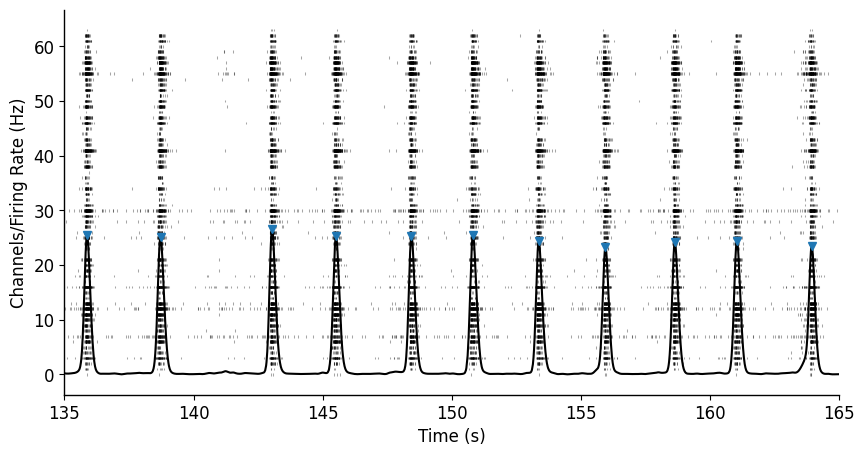

In [27]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
t = np.arange(0,duration,1/fs)
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(135,165)
plt.ylabel("Channels/Firing Rate (Hz)")
plt.xlabel("Time (s)")
sns.despine()

plt.plot(burst_peak_times, weighted_network_sdf[(burst_peak_times*fs).astype(int)], 'v')

As you can see, our really basic peak detection was able to identify the location of all the network bursts in this recording. Depending on how noisy your activity is, you may need a more complicated approach.

## Cluster burst peaks along inter-burst-peak-interval and firing rate dimensions

### Visualize data

Text(0, 0.5, 'Firing rate (Hz)')

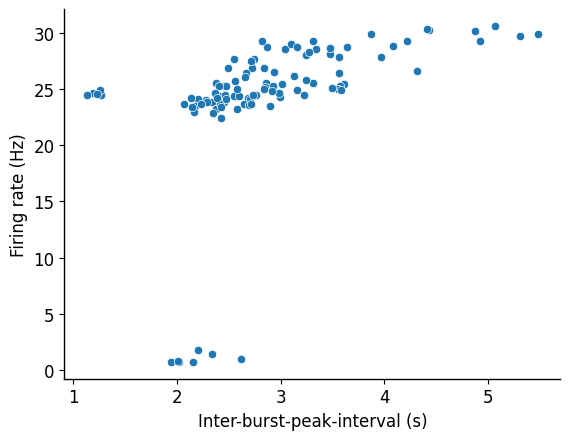

In [28]:
ibpi = np.diff(burst_peak_times)
fr = weighted_network_sdf[(burst_peak_times*fs).astype(int)]
sns.scatterplot(x=ibpi,y=fr[1:])
sns.despine()
plt.xlabel("Inter-burst-peak-interval (s)")
plt.ylabel("Firing rate (Hz)")

This approach ignores the first burst. We can deal with that later.

Importantly, this network detected small amplitude bursts that have a similar rate as mini-bursts. The important distinction is a strong overlap in the IBPI dimension. We will quantify that in the next step.

### K-means clustering

In [30]:
def k_means(ibpi, fr):
  features = np.transpose([ibpi, fr[1:]])
  #scaler = StandardScaler()
  #scaled_features = scaler.fit_transform(features)

  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 250,
      "random_state": 0
  }
  kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
  kmeans.fit(features)

  x = np.transpose(features)[0]
  y = np.transpose(features)[1]

  # Assign the mini-burst cluster as label 1
  if np.nanmean(x[kmeans.labels_==0]) > np.nanmean(x[kmeans.labels_==1]):
    cluster_x_1 = x[kmeans.labels_==0]
    cluster_x_2 = x[kmeans.labels_==1]
    cluster_y_1 = y[kmeans.labels_==0]
    cluster_y_2 = y[kmeans.labels_==1]
  else:
    cluster_x_1 = x[kmeans.labels_==1]
    cluster_x_2 = x[kmeans.labels_==0]
    cluster_y_1 = y[kmeans.labels_==1]
    cluster_y_2 = y[kmeans.labels_==0]
  #sns.scatterplot(x=cluster_x_1, y=cluster_y_1, color='green')
  #sns.scatterplot(x=cluster_x_2, y=cluster_y_2, color='red')

  # Check what the percent of overlap is
  num_of_bins = int(len(fr)/2)
  # Overlapping x
  rng_x = min(cluster_x_1.min(), cluster_x_2.min()), max(cluster_x_1.max(), cluster_x_2.max())
  n1_x, bins1_x = np.histogram(cluster_x_1, bins=num_of_bins, range=rng_x)
  n2_x, bins2_x = np.histogram(cluster_x_2, bins=num_of_bins, range=rng_x)
  intersection_x = np.minimum(n1_x,n2_x)

  overlapping_bins_x = np.nonzero(intersection_x)
  if len(overlapping_bins_x) > 0:
      overlapping_bursts_x = np.sum(n1_x[overlapping_bins_x] + n2_x[overlapping_bins_x])
      percent_overlapping_x = overlapping_bursts_x/len(x)
  else:
      percent_overlapping_x = 0

  if (percent_overlapping_x > 0.2) | (sum(kmeans.labels_==1)<sum(kmeans.labels_==0)):
    print(f"The well is probably not reverberating strongly if at all")
    return False, x, y, kmeans.labels_
  else:
    print(f"The well is probably reverberating")
    return True, x, y, kmeans.labels_


isReverb, cluster_x, cluster_y, labels = k_means(ibpi, fr)

The well is probably not reverberating strongly if at all


K-means used percent overlap along the IBPI dimension as well as the total number of labeled "mini-bursts" to initiation burst. Generally, there should be as much or more mini-bursts to initiation bursts.

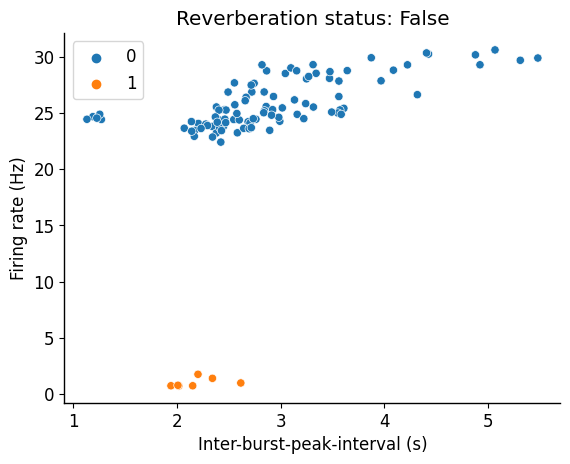

In [31]:
sns.scatterplot(x=cluster_x, y=cluster_y, hue=labels)
plt.xlabel("Inter-burst-peak-interval (s)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"Reverberation status: {isReverb}")
sns.despine()

### Inter-burst-peak-interval skewness

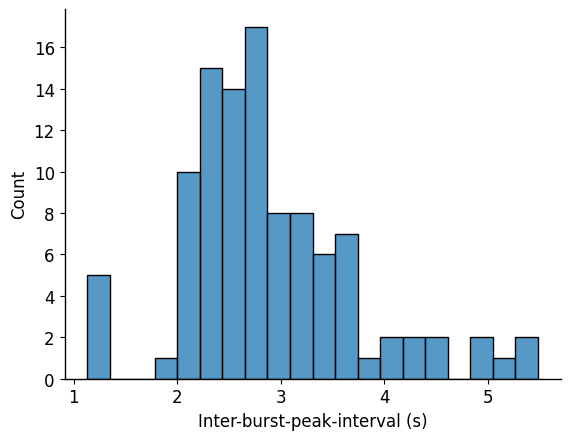

In [32]:
def burst_skewness(ibpi):
  if skew(ibpi) > 0:
    return True
  else:
    return False

ibpi_skewness = burst_skewness(burst_peak_times)

sns.histplot(data=ibpi, bins=20)
plt.xlabel("Inter-burst-peak-interval (s)")
sns.despine()

## Rmax calculation (Crawling the histogram)

**NOTE: For a non-reverberating network, we can skip this step entirely.**

There are a number of different approaches to find the local minimum between a distribution. I initially attempted using Hartigan's Dip Test (via Unidip package) but found that depending on the frequency of network events, it would struggle to detect the local minimum. The approach that I found first that worked best was trying to replicate how my visual detection worked. In essence, I would plot histograms with varying bin sizes/ number of bins and see if there was a point where there was a 0 count bin between the two clear peaks. That approach worked most of the time. The issue with it is that it goes with the first bin that has a 0 count, which may result in certain RSBs being missed. This did a good enough job to be the main approach for Pradeepan et al., 2023.

In [56]:
def hist_find_rmax(ibpi, labels, steps=2):
  initiation_burst = ibpi[labels==0]
  max_num_bins = int(len(ibpi/1.5))
  rmax = 0
  r_tmp = []
  s_tmp = []
  if (np.median(ibpi) < np.median(initiation_burst)):
    for size in (np.arange(max_num_bins, 5, -steps)):
      counts, binEdges = np.histogram(ibpi, bins=size)
      if len(np.where(counts==0)[0]) > 0:
        first_min = np.where(counts==0)[0][0]
        rmax_tmp = binEdges[first_min]
        r_tmp.append(rmax_tmp)
        s_tmp.append(size)
        if (rmax_tmp > rmax) & (rmax_tmp < (mode(list(map(int, initiation_burst)))[0]*0.9)):
          print(f"New Rmax found of {rmax_tmp} using {size} bin histogram")
          rmax = rmax_tmp
  return rmax

hist_rmax = hist_find_rmax(ibpi, labels, steps=2)
print(f"The calculated Rmax using histogram crawling was {hist_rmax} seconds.")

New Rmax found of 1.299259029126173 using 103 bin histogram
New Rmax found of 1.302605940594019 using 101 bin histogram
New Rmax found of 1.3060880808080402 using 99 bin histogram
New Rmax found of 1.3097138144329492 using 97 bin histogram
New Rmax found of 1.3134922105262754 using 95 bin histogram
New Rmax found of 1.3141374647886919 using 71 bin histogram
New Rmax found of 1.3194678260869162 using 69 bin histogram
New Rmax found of 1.3251164179104074 using 67 bin histogram
New Rmax found of 1.3311126153845751 using 65 bin histogram
New Rmax found of 1.3374895238094835 using 63 bin histogram
New Rmax found of 1.3425443902438623 using 41 bin histogram
New Rmax found of 1.3534317948717547 using 39 bin histogram
New Rmax found of 1.3654962162161761 using 37 bin histogram
New Rmax found of 1.3789394285713887 using 35 bin histogram
New Rmax found of 1.3940121212120813 using 33 bin histogram
New Rmax found of 1.4203893333332938 using 15 bin histogram
New Rmax found of 1.465027692307653 usin

Because there are two clusters, Rmax calculation attempted to find a minimum. This would give us false boundaries. That is why in the burst reconstruction loop, "isReverb" needs to be true to use Rmax.

## Rmax calculation (Simple overlap)

In [34]:
def overlap_find_rmax(ibpi, labels):
  initiation_bursts = ibpi[labels==0]
  mini_bursts = ibpi[labels==1]

  overlap_start = max(min(initiation_bursts), min(mini_bursts))
  overlap_end = min(max(initiation_bursts), max(mini_bursts))

  return overlap_start

overlap_rmax = overlap_find_rmax(ibpi, labels)
print(f"The calculated Rmax using min overlap was {overlap_rmax} seconds.")

The calculated Rmax using min overlap was 1.9411200000000122 seconds.


This is an alternative approach that is computationally cheaper and works as well.

You can use these functions to also calculate Amax, or the maximum amplitude to be considered a mini-bursts.

# Burst Detection Loop
This part of the algorithm calculates the ordinary burst boundaries (regardless of RSB status). These burst boundaries will be merged in the next step.

Recall, this is our spike density function. We are going to detect where the bursts start and end. Generally these line up when the first derivative peaks (i.e., begins to decline).

Text(0.5, 0, 'Time (s)')

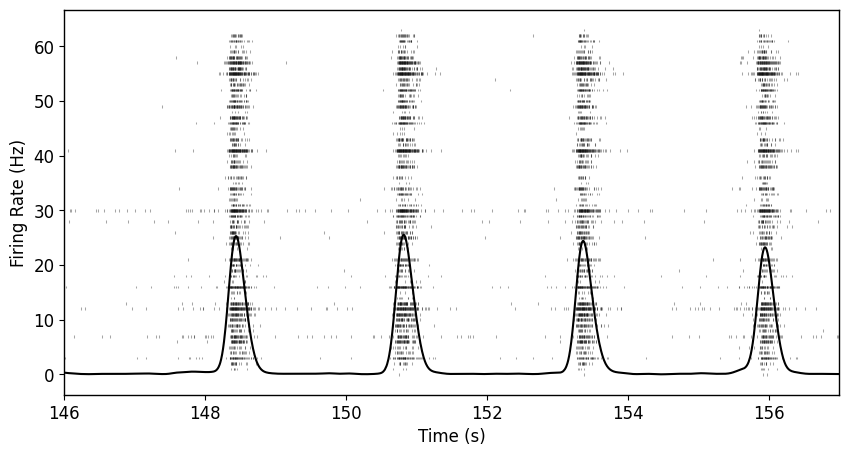

In [35]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
t = np.arange(0,duration,1/fs)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(146, 157)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

(146.0, 149.0)

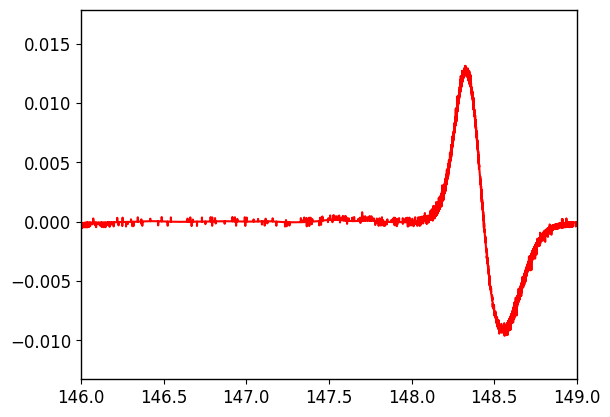

In [36]:
plt.plot(t[1:], np.diff(weighted_network_sdf), color='red')
plt.xlim(146, 149)

## Resample the signal

However, as you can tell, because of the sampling frequency of the original signal (12.5kHz), the signal is too noisy. This will make detecting any local maxima or minima difficult.

To address, we are going to downsample the original SDF. In hindsight, you could do this much earlier one when first generating your spike density function. It should be more appropriately placed in the "Signal Conditioning" section.

In [37]:
RESAMPLE_FACTOR = 150
ds_weighted_network_sdf = resample(weighted_network_sdf, int(len(weighted_network_sdf)/RESAMPLE_FACTOR))

Sanity check, but a resample factor of 150 seems to be good for us. Preserves enough.

(146.0, 157.0)

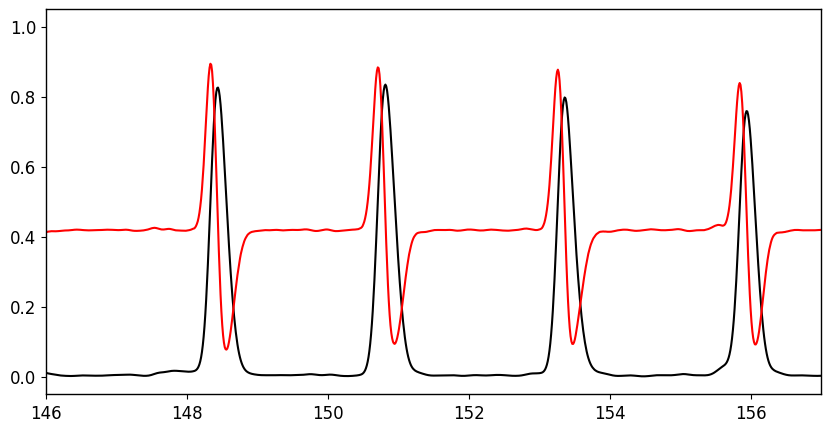

In [38]:
# Scale the arrays between 0 and 1 so that we can plot the SDF and the first
# derivative together and see them both
min_max_scaler = MinMaxScaler()
scaled_ds_sdf = min_max_scaler.fit_transform(ds_weighted_network_sdf.reshape(-1,1))
t = np.arange(0,duration,RESAMPLE_FACTOR/fs)
first_deriv = np.diff(ds_weighted_network_sdf)

scaled_first_deriv = min_max_scaler.fit_transform(first_deriv.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.plot(t, scaled_ds_sdf.reshape(1,-1)[0], color='black')
plt.plot(t[1:], scaled_first_deriv.reshape(1,-1)[0], color='red')
plt.xlim(146, 157)

Signal looks a lot smoother. Peaks of first derivative align with where burst starts and troughs align where burst generally end.

## Detect the beginning and end based on the peaks and troughs of the first derivative

In [39]:
# Resample spike density function
ds_weighted_network_sdf = resample(weighted_network_sdf, int(len(weighted_network_sdf)/RESAMPLE_FACTOR))
# Generate a new time array
t = np.arange(0,duration,RESAMPLE_FACTOR/fs)

# Detect positive peaks (representing when the rate of increase is just about to go negative)
burst_start_ind,_ = find_peaks(np.diff(ds_weighted_network_sdf), prominence=0.1)
# Detect positive peaks of negative SDF (representing when the rate of increase is just about to go positive)
burst_end_ind,_ = find_peaks(-np.diff(ds_weighted_network_sdf), prominence=0.1)

# Assign detected peaks a time
burst_start = t[burst_start_ind]
burst_end = t[burst_end_ind]

# Check if the array length is the same. In some cases, it may not be and you
# can either drop the extra value where the start and end do not alternate or you
# can put a bit of work and find the value.
print(f"Length of burst_start is {len(burst_start)} and burst_end is {len(burst_end)}")

Length of burst_start is 100 and burst_end is 100


### Visualize the above work

(146.0, 157.0)

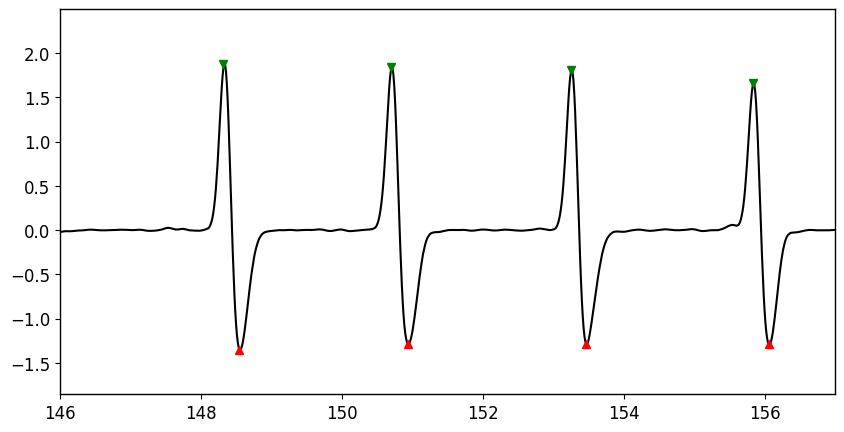

In [40]:
plt.figure(figsize=(10,5))
first_deriv = np.diff(ds_weighted_network_sdf)
plt.plot(t[1:],first_deriv, color='black')
plt.plot(burst_start, first_deriv[burst_start_ind], 'v', color='green')
plt.plot(burst_end, first_deriv[burst_end_ind], '^', color='red')
plt.xlim(146, 157)

### Wrap the above into a function as we don't need to be doing this type of EDA (exploratory data analysis) every time.

In [41]:
def detect_burst_boundaries(weighted_network_sdf, RESAMPLE_FACTOR=150):
  ds_weighted_network_sdf = resample(weighted_network_sdf, int(len(weighted_network_sdf)/RESAMPLE_FACTOR))
  t = np.arange(0,duration,RESAMPLE_FACTOR/fs)
  burst_start_ind,_ = find_peaks(np.diff(ds_weighted_network_sdf), prominence=0.1)
  burst_end_ind,_ = find_peaks(-np.diff(ds_weighted_network_sdf), prominence=0.1)
  burst_start = t[burst_start_ind]
  burst_end = t[burst_end_ind]
  print(f"Length of burst_start is {len(burst_start)} and burst_end is {len(burst_end)}")
  return burst_start, burst_end

burst_start, burst_end = detect_burst_boundaries(weighted_network_sdf)

Length of burst_start is 100 and burst_end is 100


## Assign burst boundaries to the peaks that were detected (if possible)

In [42]:
burst_borders = []
for burst_peak in burst_peak_times:
  closest_start_to_peak = burst_start[burst_start < burst_peak].max()
  closest_end_to_peak = burst_end[burst_end > burst_peak].min()
  burst_borders.append((closest_start_to_peak, closest_end_to_peak))

Text(0.5, 0, 'Time (s)')

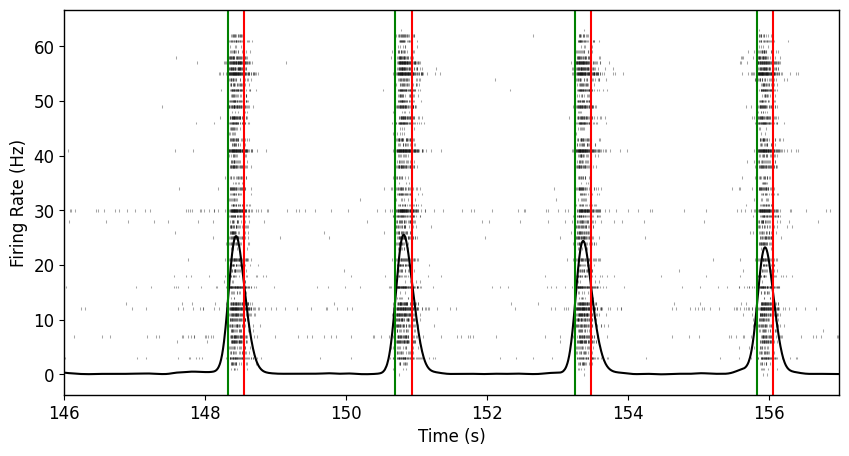

In [43]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
t = np.arange(0,duration,1/fs)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(146, 157)
for b in burst_borders:
  plt.axvline(b[0], color='green')
  plt.axvline(b[1], color='red')
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

First derivative burst detection does a decent job. In this case, the network bursts may be terminating a bit too quickly. You can adjust this if you'd like but we'll keep going. Importantly, there are no nested mini-bursts.

# Reverberating Super Burst Reconstruction Loop
Now that we have our Rmax (and if necessary, Amax) as well as our preliminary burst boundaries, we can now reconstructing the network events into reverberating super bursts if they meet the appropriate criteria. Do this only if "isReverb" is True.

**In this example, isReverb is false and therefore we will not proceed with reconstruction. Instead we will assign network event variables (ne_start, ne_end) as the burst boundaries we calculated just above.**

Text(0.5, 0, 'Time (s)')

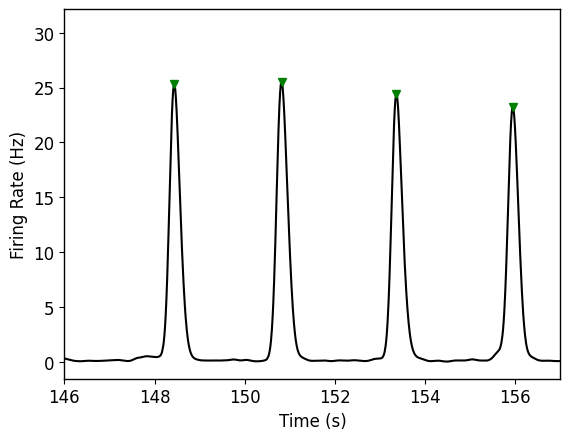

In [57]:
burst_peaks = burst_peak_times[1:] # Because we ignored the first burst above

initiation_bursts = burst_peaks[labels==0]
mini_bursts = burst_peaks[labels==1]

t = np.arange(0,duration,1/12500)
plt.plot(t,weighted_network_sdf, color='black')
plt.plot(initiation_bursts, weighted_network_sdf[(initiation_bursts*fs).astype(int)], 'v', color='green')
plt.plot(mini_bursts, weighted_network_sdf[(mini_bursts*fs).astype(int)], 'v', color='red')
plt.xlim(146, 157)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

## Merge the burst boundaries of all possible bursts into larger, complex network events if they meet the criteria

In [49]:
def merge_bursts_into_RSB(rmax, burst_borders, prime_burst_peak_times, burst_peak_times):
  '''
  Rmax: either hist_rmax or overlap_rmax
  Burst borders: start and end tuple for each burst peak that we just recently calculated
  Prime_burst_peak_times: a variable we calculated close to the top where the only peaks
  would meet the criteria of a high prominence were detected
  Burst_peak_times: all possible burst peaks
  '''
  ne_start = []
  ne_end = []
  nReverbs = []
  r = 0
  in_super_burst = False
  initial_burst = False

  for i in range(0, len(burst_borders)-1):
    if (burst_peak_times[i] in prime_burst_peak_times) & (initial_burst == True):
      initial_burst = False
      ne_end.append(burst_borders[i-1][1])
      nReverbs.append(r)
      r = 0
    if (burst_peak_times[i] in prime_burst_peak_times) & (initial_burst == False):
      initial_burst = True
      ne_start.append(burst_borders[i][0])
    if ((burst_borders[i+1][0] - burst_borders[i][1]) <= rmax) & (initial_burst == True):
      if in_super_burst:
        r += 1
      in_super_burst = True
    elif ((burst_borders[i + 1][0] - burst_borders[i][1]) > rmax) & (initial_burst == True):
      if in_super_burst:
        r += 1
        in_super_burst = False
        initial_burst = False
        ne_end.append(burst_borders[i][1])
        nReverbs.append(r)
        r = 0
  if (burst_peak_times[len(burst_borders) - 1] in prime_burst_peak_times):
   ne_start.append(burst_borders[i][0])
   ne_end.append(burst_borders[i][1])
  else:
   ne_end.append(burst_borders[i][1])
   nReverbs.append(r)
  return ne_start, ne_end, nReverbs

if isReverb==True:
  ne_start, ne_end, nReverbs = merge_bursts_into_RSB(overlap_rmax, burst_borders, prime_burst_peak_times, burst_peak_times)
else:
  ne_start = [b[0] for b in burst_borders]
  ne_end = [b[1] for b in burst_borders]
  nReverbs = np.zeros(len(burst_borders))

### Visualize if the merging worked appropriately

Text(0.5, 0, 'Time (s)')

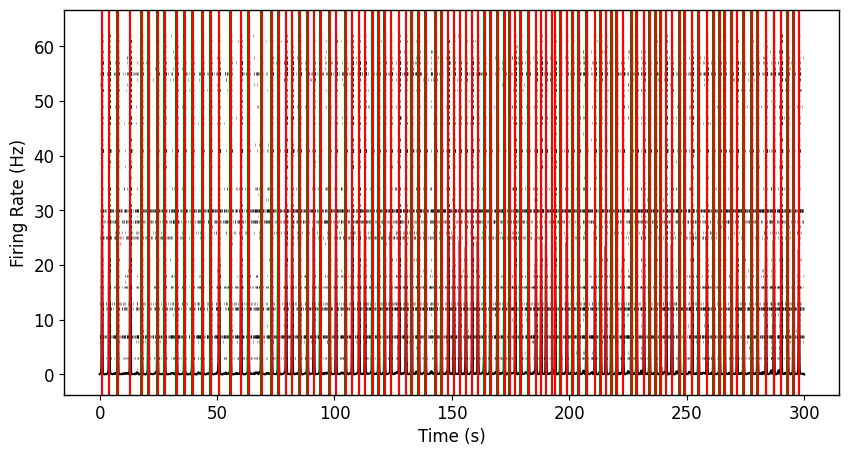

In [50]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
t = np.arange(0,duration,1/fs)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.plot(t,weighted_network_sdf, color='black')
for b in ne_start:
  plt.axvline(b, color='green')
for b in ne_end:
  plt.axvline(b, color='red')
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

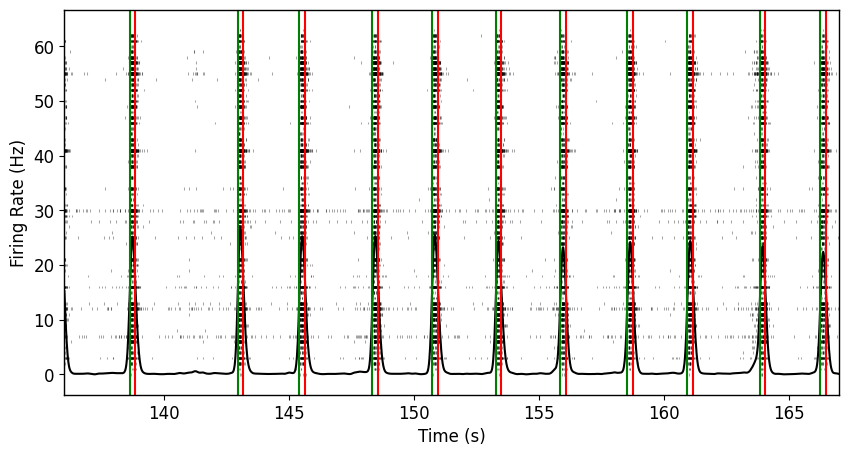

In [51]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', linewidth=1)
t = np.arange(0,duration,1/fs)
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35);
plt.plot(t,weighted_network_sdf, color='black')
plt.xlim(136, 167)
for b in ne_start:
  plt.axvline(b, color='green')
for b in ne_end:
  plt.axvline(b, color='red')
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

## and there you have it! 🎉🎉🎉 Detection of network events using the same code as the reverberating super burst detection. You can similarily proceed with calculating features however reverberating super burst specific features will not be informative.

.

.

# Feature Calculation

### Number of mini-bursts per reverberating super burst

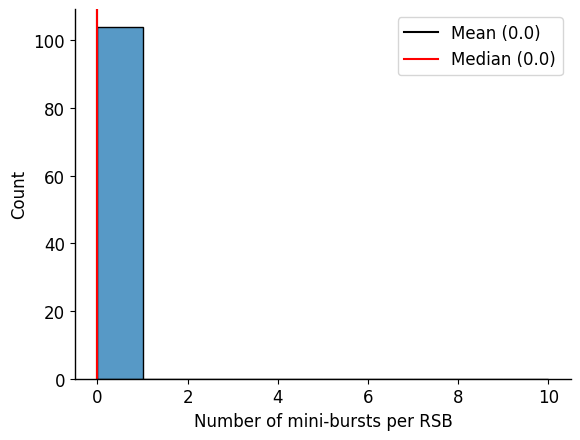

In [52]:
sns.histplot(data=nReverbs, binrange=(0,10), bins=10)
plt.xlabel("Number of mini-bursts per RSB")
plt.axvline(np.mean(nReverbs), color='black')
plt.axvline(np.median(nReverbs), color='red')
plt.legend([f"Mean ({np.mean(nReverbs)})",f"Median ({np.median(nReverbs)})"])
sns.despine()

This network had a median number of 4 mini-bursts per reverberating super bursts. Quite the active one! In this case, not a single non-reverberating network event was seen.

### Network Event Duration

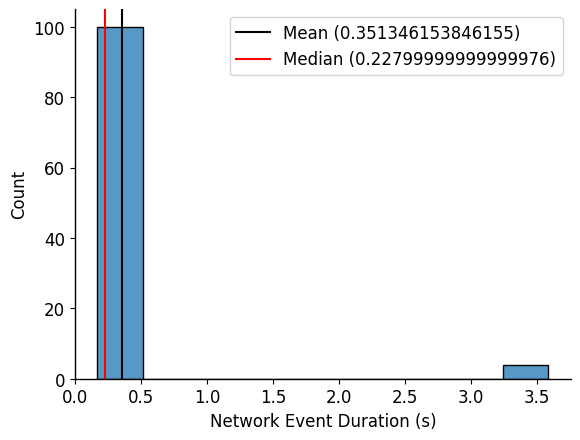

In [53]:
ne_duration = [ne_end[i]-ne_start[i] for i in range(len(ne_start))]

sns.histplot(data=ne_duration, bins=10)
plt.xlabel("Network Event Duration (s)")
plt.axvline(np.mean(ne_duration), color='black')
plt.axvline(np.median(ne_duration), color='red')
plt.legend([f"Mean ({np.mean(ne_duration)})",f"Median ({np.median(ne_duration)})"])
sns.despine()

On average, this network had a network event duration of approximately 2 seconds. Based on this duration, and the previously calculated number of mini-bursts, what is the mini-burst frequency per reverberating super burst?

### Mini-burst Frequency

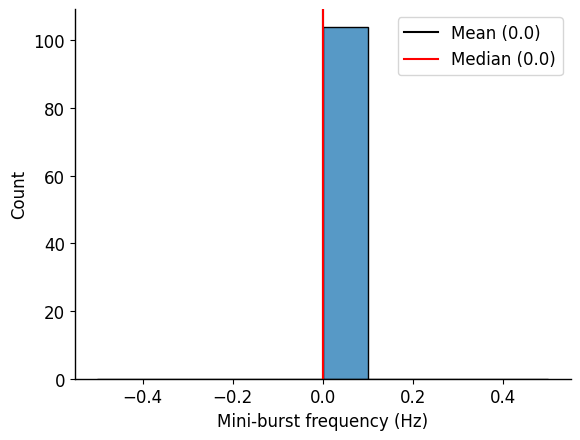

In [54]:
mb_frequency = [nReverbs[b]/ne_duration[b] for b in range(len(ne_duration))]

sns.histplot(data=mb_frequency, bins=10)
plt.xlabel("Mini-burst frequency (Hz)")
plt.axvline(np.mean(mb_frequency), color='black')
plt.axvline(np.median(mb_frequency), color='red')
plt.legend([f"Mean ({np.mean(mb_frequency)})",f"Median ({np.median(mb_frequency)})"])
sns.despine()

The vast majority of reverberating super bursts had a mini-burst frequency between 1.5-2.1 Hz. Fairly consistent frequency.

### Inter-Network-Event-Interval

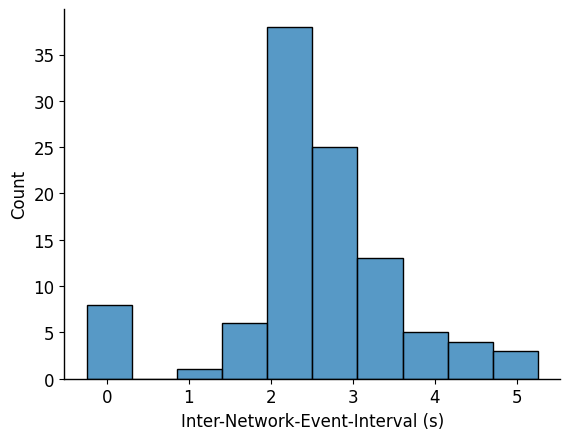

In [55]:
i_ne_i = [ne_start[i+1]-ne_end[i] for i in range(0,len(ne_start)-1)]

sns.histplot(data=i_ne_i, bins=10)
plt.xlabel("Inter-Network-Event-Interval (s)")
sns.despine()